In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Загрузка данных
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")
sample_submission = pd.read_csv("submission.csv")


In [3]:
# Создание копии DataFrame для LSTM
train_lstm = train.copy()

# Заполнение NaN в 'values' нулями
train_lstm['values'] = train_lstm['values'].apply(lambda x: [0.0 if pd.isnull(v) else v for v in x])

# Создание маски: 1 если значение присутствует, 0 если заполнено (0.0)
train_lstm['mask'] = train_lstm['values'].apply(lambda x: [0 if v == 0.0 else 1 for v in x])


In [4]:
# Функция для преобразования дат в временные метки
def convert_dates_to_timestamps(dates_array):
    if isinstance(dates_array, np.ndarray):
        dates_list = dates_array.tolist()
    else:
        dates_list = dates_array

    timestamps = []
    for date_item in dates_list:
        if isinstance(date_item, datetime.date) and not isinstance(date_item, datetime.datetime):
            date_obj = datetime.datetime.combine(date_item, datetime.time())
        elif isinstance(date_item, datetime.datetime):
            date_obj = date_item
        elif isinstance(date_item, str):
            try:
                date_obj = datetime.datetime.strptime(date_item, '%Y-%m-%d')
            except ValueError:
                date_obj = pd.to_datetime(date_item, errors='coerce').to_pydatetime()
                if pd.isnull(date_obj):
                    raise ValueError(f"Не удалось преобразовать строку в дату: {date_item}")
        else:
            raise ValueError(f"Неизвестный формат даты: {date_item} (тип {type(date_item)})")
        timestamp = date_obj.timestamp()
        timestamps.append(timestamp)
    return timestamps

# Применение функции к столбцу 'dates'
train_lstm['timestamps'] = train_lstm['dates'].apply(convert_dates_to_timestamps)


In [5]:
# Объединение значений, временных меток и маски
def combine_features(row):
    values = row['values']
    timestamps = row['timestamps']
    mask = row['mask']

    combined = [[v, t, m] for v, t, m in zip(values, timestamps, mask)]
    return combined

train_lstm['combined'] = train_lstm.apply(combine_features, axis=1)


In [6]:
# Создание списков входных данных и меток
X = train_lstm['combined'].tolist()
y = train_lstm['label'].tolist()


In [7]:
# Находим максимальную длину последовательностей
max_len = max(len(seq) for seq in X)

# Собираем все значения и временные метки для масштабирования
all_values = [value for seq in X for value, _, _ in seq]
all_timestamps = [timestamp for seq in X for _, timestamp, _ in seq]

# Масштабирование
scaler_values = StandardScaler()
scaler_values.fit(np.array(all_values).reshape(-1, 1))

scaler_timestamps = StandardScaler()
scaler_timestamps.fit(np.array(all_timestamps).reshape(-1, 1))

# Функция для масштабирования последовательностей
def scale_sequence(sequence, scaler_values, scaler_timestamps):
    values = [item[0] for item in sequence]
    timestamps = [item[1] for item in sequence]
    mask = [item[2] for item in sequence]

    # Масштабирование значений и временных меток
    values_scaled = scaler_values.transform(np.array(values).reshape(-1, 1)).flatten()
    timestamps_scaled = scaler_timestamps.transform(np.array(timestamps).reshape(-1, 1)).flatten()

    return [[v, t, m] for v, t, m in zip(values_scaled, timestamps_scaled, mask)]

# Применение масштабирования к X
X_scaled = [scale_sequence(seq, scaler_values, scaler_timestamps) for seq in X]


In [8]:

def pad_sequences_pytorch(sequences, max_len, pad_value=0.0):
    padded_sequences = []
    lengths = []
    for seq in sequences:
        seq_len = len(seq)
        lengths.append(seq_len)
        if seq_len < max_len:
            # Дополнение [0.0, 0.0, 0.0] в конце
            padded_seq = seq + [[pad_value, pad_value, 0.0]] * (max_len - seq_len)
        else:
            padded_seq = seq[:max_len]
        padded_sequences.append(padded_seq)
    return torch.tensor(padded_sequences, dtype=torch.float32), torch.tensor(lengths, dtype=torch.long)

# Паддинг последовательностей
X_padded, lengths = pad_sequences_pytorch(X_scaled, max_len, pad_value=0.0)


In [9]:
# Преобразование y в PyTorch тензор
y = torch.tensor(y, dtype=torch.float32)


In [10]:
print("Форма X_padded:", X_padded.shape)  # (num_samples, max_len, 3)
print("Тип данных X_padded:", X_padded.dtype)  # float32

print("Форма lengths:", lengths.shape)  # (num_samples,)
print("Тип данных lengths:", lengths.dtype)  # long

print("Форма y:", y.shape)  # (num_samples,)
print("Тип данных y:", y.dtype)  # float32


Форма X_padded: torch.Size([80000, 97, 3])
Тип данных X_padded: torch.float32
Форма lengths: torch.Size([80000])
Тип данных lengths: torch.int64
Форма y: torch.Size([80000])
Тип данных y: torch.float32


In [11]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, lengths, labels):
        self.sequences = sequences
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.labels[idx]


In [12]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, lengths_train, lengths_test, y_train, y_test = train_test_split(
    X_padded, lengths, y, test_size=0.2, random_state=42, shuffle=True
)


In [13]:
# Создание датасетов
train_dataset = SequenceDataset(X_train, lengths_train, y_train)
test_dataset = SequenceDataset(X_test, lengths_test, y_test)


In [14]:
def collate_fn(batch):
    # batch: list of tuples (sequence, length, label)
    sequences, lengths, labels = zip(*batch)

    # Сортировка по длине последовательности в порядке убывания
    lengths, perm_idx = torch.tensor(lengths).sort(0, descending=True)
    sequences = torch.stack(sequences)[perm_idx]
    labels = torch.stack(labels)[perm_idx]

    return sequences, lengths, labels


In [15]:

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

print(f"Количество обучающих примеров: {len(train_dataset)}")
print(f"Количество тестовых примеров: {len(test_dataset)}")


Количество обучающих примеров: 64000
Количество тестовых примеров: 16000


In [16]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        # С BCEWithLogitsLoss не нужна функция активации здесь
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # x: [batch_size, seq_len, input_dim]
        # lengths: [batch_size]

        # pack_padded_sequence требует, чтобы последовательности были отсортированы по длине в порядке убывания
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True)

        packed_output, (hn, cn) = self.lstm(packed_input)
        # hn: [num_layers * num_directions, batch_size, hidden_dim]

        # Для однонаправленного LSTM берем последний слой
        hn = hn[-1]  # [batch_size, hidden_dim]

        out = self.dropout(hn)
        out = self.fc(out)  # [batch_size, 1]
        # out = self.sigmoid(out)  # Для BCEWithLogitsLoss не нужно
        return out.squeeze()  # [batch_size]


In [17]:
# Проверка наличия GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Инициализация модели (используйте LSTMClassifier или BiLSTMClassifier)
model = LSTMClassifier(input_dim=3, hidden_dim=64, num_layers=1, dropout=0.5)
# model = BiLSTMClassifier(input_dim=3, hidden_dim=64, num_layers=2, dropout=0.5)  # Для двунаправленного

model.to(device)

# Вычисление весов классов для обработки дисбаланса
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Преобразование весов для положительного и отрицательного класса
# Используем BCEWithLogitsLoss с pos_weight
if len(class_weights) > 1:
    pos_weight = class_weights[1] / class_weights[0]
else:
    pos_weight = torch.tensor([1.0]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Используемое устройство: cpu


In [18]:
def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for sequences, lengths, labels in data_loader:
            sequences = sequences.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)
            outputs = model(sequences, lengths)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    auc = roc_auc_score(all_labels, all_preds)
    return auc, all_labels, all_preds


In [19]:

num_epochs = 30  # Максимальное количество эпох
patience = 5  # Параметр ранней остановки
best_val_auc = 0
trigger_times = 0

# Шедулер для адаптивного изменения скорости обучения
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

train_auc_history = []
val_auc_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_losses = []
    for sequences, lengths, labels in train_loader:
        sequences = sequences.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    # Средняя потеря за эпоху
    avg_loss = np.mean(epoch_losses)

    # Оценка на обучающей выборке
    train_auc, _, _ = evaluate(model, train_loader)
    # Оценка на валидационной выборке
    val_auc, _, _ = evaluate(model, test_loader)

    train_auc_history.append(train_auc)
    val_auc_history.append(val_auc)

    print(f"Эпоха {epoch}/{num_epochs} | Потеря: {avg_loss:.4f} | Train ROC AUC: {train_auc:.4f} | Val ROC AUC: {val_auc:.4f}")

    # Шедулер
    scheduler.step(val_auc)

    # Ранняя остановка
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        trigger_times = 0
        # Сохранение лучших весов
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Ранняя остановка")
            break

# Загрузка лучших весов
model.load_state_dict(torch.load('best_model.pth'))


Эпоха 1/30 | Потеря: 0.7498 | Train ROC AUC: 0.8373 | Val ROC AUC: 0.8397
Эпоха 2/30 | Потеря: 0.7057 | Train ROC AUC: 0.8573 | Val ROC AUC: 0.8563
Эпоха 3/30 | Потеря: 0.6756 | Train ROC AUC: 0.8673 | Val ROC AUC: 0.8658
Эпоха 4/30 | Потеря: 0.6342 | Train ROC AUC: 0.8985 | Val ROC AUC: 0.8967
Эпоха 5/30 | Потеря: 0.5696 | Train ROC AUC: 0.9115 | Val ROC AUC: 0.9083
Эпоха 6/30 | Потеря: 0.5570 | Train ROC AUC: 0.9145 | Val ROC AUC: 0.9129
Эпоха 7/30 | Потеря: 0.5462 | Train ROC AUC: 0.9144 | Val ROC AUC: 0.9125
Эпоха 8/30 | Потеря: 0.5417 | Train ROC AUC: 0.9208 | Val ROC AUC: 0.9189
Эпоха 9/30 | Потеря: 0.5347 | Train ROC AUC: 0.9213 | Val ROC AUC: 0.9186
Эпоха 10/30 | Потеря: 0.5320 | Train ROC AUC: 0.9243 | Val ROC AUC: 0.9206
Эпоха 11/30 | Потеря: 0.5275 | Train ROC AUC: 0.9247 | Val ROC AUC: 0.9210
Эпоха 12/30 | Потеря: 0.5254 | Train ROC AUC: 0.9223 | Val ROC AUC: 0.9178
Эпоха 13/30 | Потеря: 0.5217 | Train ROC AUC: 0.9256 | Val ROC AUC: 0.9218
Эпоха 14/30 | Потеря: 0.5183 | Tra

<All keys matched successfully>

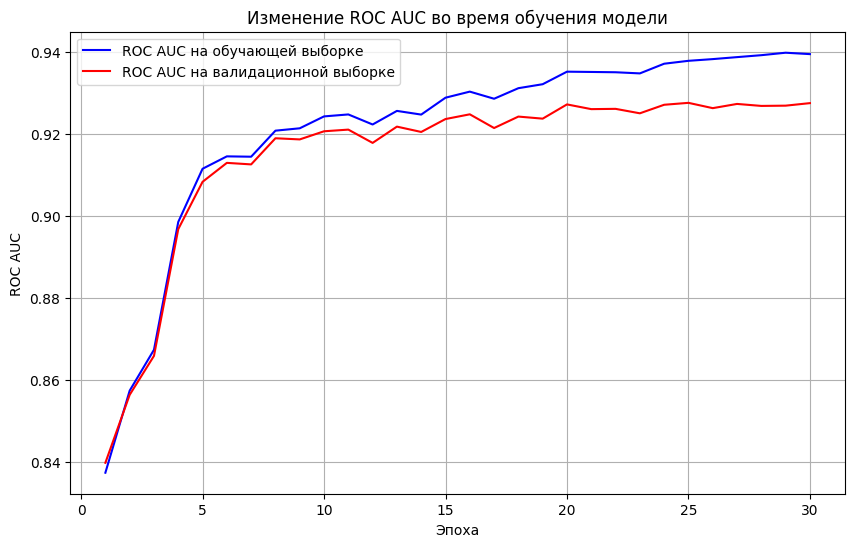

In [20]:
# Визуализация ROC AUC
epochs_range = range(1, len(train_auc_history) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_auc_history, 'b-', label='ROC AUC на обучающей выборке')
plt.plot(epochs_range, val_auc_history, 'r-', label='ROC AUC на валидационной выборке')
plt.title('Изменение ROC AUC во время обучения модели')
plt.xlabel('Эпоха')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()


Итоговый ROC AUC на тестовом наборе: 0.9276


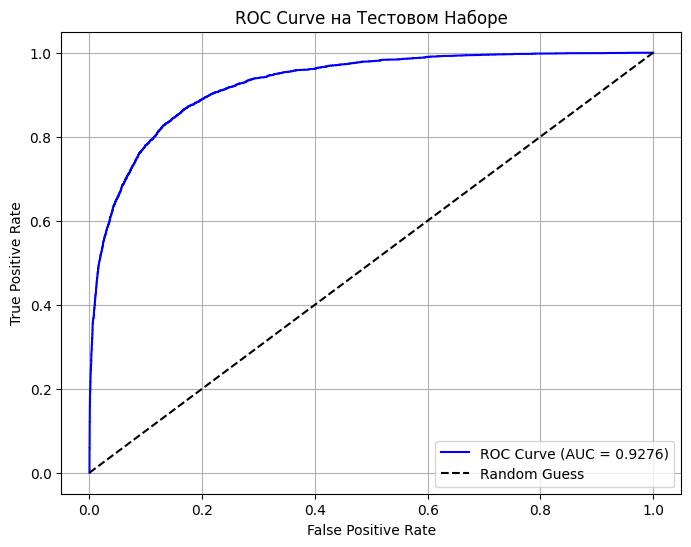

In [21]:
# Используем all_labels и all_preds из последней итерации цикла обучения
_, all_labels, all_preds = evaluate(model, test_loader)

# Вычисление ROC AUC
roc_auc = roc_auc_score(all_labels, all_preds)
print(f"Итоговый ROC AUC на тестовом наборе: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Диагональная линия для случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на Тестовом Наборе')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()